# Road Segmentation Project


In [1]:
# Imports
import math
import os
import re
import cv2
import torch
import numpy as np
import parameters as params
import utils
import trainer
import matplotlib.pyplot as plt
from glob import glob
from random import sample
from PIL import Image
from torch import nn
from sklearn.model_selection import train_test_split

In [2]:
# Loading data
images = utils.load_all_from_path(os.path.join(params.ROOT_PATH, 'training', 'images'))[:, :, :, :3]
masks = utils.load_all_from_path(os.path.join(params.ROOT_PATH, 'training', 'groundtruth'))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.1, random_state=42
)
train_patches, train_labels = utils.image_to_patches(train_images, train_masks)
val_patches, val_labels = utils.image_to_patches(val_images, val_masks)

In [3]:
class ImageDataset(torch.utils.data.Dataset):
    # dataset class that deals with loading the data and making it available by index.

    def __init__(self, mode, device, use_patches=True, resize_to=(400, 400)):
        self.mode = mode
        self.device = device
        self.use_patches = use_patches
        self.resize_to=resize_to
        self.x, self.y, self.n_samples = None, None, None
        self._load_data()

    def _load_data(self):  # not very scalable, but good enough for now
        # select dataset
        match self.mode:
            case 'train':
                self.x = train_images
                self.y = train_masks
            case 'val':
                self.x = val_images
                self.y = val_masks
            case 'full':
                self.x = images
                self.y = masks

        if self.use_patches:  # split each image into patches
            self.x, self.y = utils.image_to_patches(self.x, self.y)
        elif self.resize_to != (self.x.shape[1], self.x.shape[2]):  # resize images
            self.x = np.stack([cv2.resize(img, dsize=self.resize_to) for img in self.x], 0)
            self.y = np.stack([cv2.resize(mask, dsize=self.resize_to) for mask in self.y], 0)
        self.x = np.moveaxis(self.x, -1, 1)  # pytorch works with CHW format instead of HWC
        self.n_samples = len(self.x)

    def _preprocess(self, x, y):
        # to keep things simple we will not apply transformations to each sample,
        # but it would be a very good idea to look into preprocessing
        return x, y

    def __getitem__(self, item):
        return self._preprocess(utils.np_to_tensor(self.x[item], self.device), utils.np_to_tensor(self.y[[item]], self.device))

    def __len__(self):
        return self.n_samples

In [4]:
# reshape the image to simplify the handling of skip connections and maxpooling
train_dataset = ImageDataset('train', device, use_patches=False, resize_to=(params.RESIZE, params.RESIZE))
val_dataset = ImageDataset('val', device, use_patches=False, resize_to=(params.RESIZE, params.RESIZE))
full_dataset = ImageDataset('full', device, use_patches=False, resize_to=(params.RESIZE, params.RESIZE))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=params.BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=params.BATCH_SIZE, shuffle=True)
full_dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=params.BATCH_SIZE, shuffle=True)

# Baselines

## Baseline 1: UNet 
This is the provided baseline U-Net with F1 score of 86%.

## Baseline 2: ResU-Net --> Road Extraction by Deep Residual U-Net
This is the provided baseline U-Net with F1 score of 89%.

In [5]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [11]:
# TRAINING WITH VALIDATIONs
# for image segmentation dice loss could be the best first choice
model = model.to(device)
loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
metric_fns = {'patch_acc': trainer.patch_accuracy_fn}
optimizer = torch.optim.Adam(model.parameters())
trainer.train_smp(train_dataloader, val_dataloader, model, loss_fn, metric_fns, optimizer, 100, 20)

Epoch 1/100:   0%|          | 0/33 [00:00<?, ?it/s]

KeyboardInterrupt: 

Epoch 1/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/36 [00:00<?, ?it/s]

Finished Training


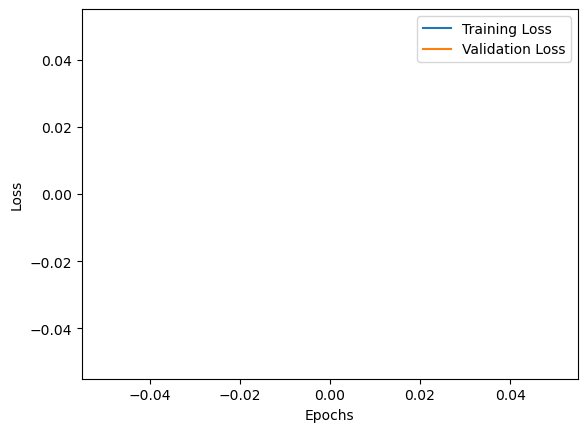

In [10]:
# TRAINING WITHOUT VALIDATION ON FULL DATASET

model_full = smp.UnetPlusPlus(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

model_full = model_full.to(device)
loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
metric_fns = {'patch_acc': trainer.patch_accuracy_fn}
optimizer = torch.optim.Adam(model.parameters())
trainer.train_smp(full_dataloader, None, model, loss_fn, metric_fns, optimizer, 100, 20)

In [9]:
utils.create_submission("test", "images",'resunet_submission.csv', model, device)

In [ ]:
import resunet

In [ ]:
model = resunet.ResUnet(3).to(device)
loss_fn = nn.BCELoss()
metric_fns = {'acc': trainer.accuracy_fn, 'patch_acc': trainer.patch_accuracy_fn}
optimizer = torch.optim.Adam(model.parameters())
trainer.train(train_dataloader, val_dataloader, model, loss_fn, metric_fns, optimizer, 100)

In [ ]:
utils.create_submission("test", "images",'resunet_submission.csv', model, device)

# Upgrade 1 - Using Transfer Learning for the Encoder
In the architecture of the U-Net, the encoder is replaced with pretrained VGG16 model.

### Training


## Upgrade 2 - CGAN --> https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8628717
In the paper, they use a simple Unet architecture. I tried transfer learning in this part (did not give a better score).

## Upgrade 2.3 -- CGAN with DCED Framework --> Road Segmentation of Remotely-Sensed Images Using Deep Convolutional Neural Networks with Landscape Metrics and Conditional Random Fields
In this framework, the writers use 4 additional ideas.
1. Using ELU activation function instead of RELU
2. Using Gaussian Smoothing and Connected Component Labeling
3. False Road Object Removal with LMs
4. Road Object Sharpening with CRFs

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [ ]:
model = model.to(device)

In [ ]:
loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}
optimizer = torch.optim.Adam(model.parameters())
train(train_dataloader, val_dataloader, model, loss_fn, metric_fns, optimizer, 10)